In [1]:
import numpy as np 
import pandas as pd

# visualizations
import matplotlib.pyplot as plt
#import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from sklearn import metrics

# time series related 
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from timeit import default_timer as timer

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [2]:
dataTA = pd.read_csv('dataTA.csv', parse_dates=['Tahun'], index_col='Tahun')
dataTA.index.freq = 'MS'

In [3]:
dataTA.tail(12)

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2021-01-01,177.0,23.32,80.10,3.11
2021-02-01,152.0,23.48,80.18,3.90
2021-03-01,167.0,23.65,80.29,4.72
2021-04-01,194.0,23.72,77.37,5.86
2021-05-01,311.0,24.09,79.26,5.74
2021-06-01,273.0,23.49,80.33,5.06
2021-07-01,242.0,23.14,72.94,7.24
2021-08-01,366.0,23.48,73.23,6.28
2021-09-01,347.0,23.84,74.70,5.22


In [4]:
# drop the null values if any
dataTA.dropna(inplace=True)
dataTA.shape

(120, 4)

PLOT DATA

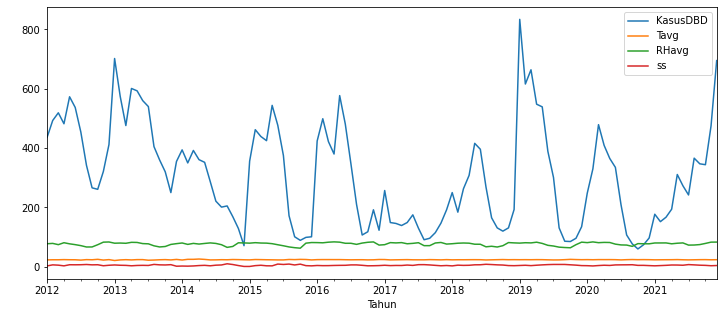

In [5]:
ylabel= ' '
xlabel= 'Tahun'

ax = dataTA['KasusDBD'].plot(figsize=(12,5),legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
dataTA['Tavg'].plot(legend=True);
dataTA['RHavg'].plot(legend=True);
dataTA['ss'].plot(legend=True);


TEST FOR STATIONARITY

In [6]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    datatest = adfuller(series, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in datatest[4].items():
       dataoutput['Critical Value (%s)'%key] = value
    print (dataoutput)
    if datatest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [7]:
for name, column in dataTA[['KasusDBD', 'Tavg', 'RHavg', 'ss']].iteritems():
    Augmented_Dickey_Fuller_Test_func(dataTA[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                  -4.822679
p-value                          0.000049
No Lags Used                     4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Tavg
Test Statistic                  -3.634114
p-value                          0.005141
No Lags Used                    12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: RHavg
Test Statistic                  -2.621707
p-value                          0.088593
No Lags Used          

TRAIN TEST SPLIT

In [8]:
n = 12 # The last 12 months will be the test data. At least 1 year would be a good choice
train = dataTA[0:-n]
test = dataTA[-n:]

In [9]:
dataTA_transformed = train.diff().diff() # 2nd order difference
dataTA_transformed = dataTA_transformed.dropna() # remove the NaNs introduced due to differencing
dataTA_transformed.head()

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2012-03-01,-31.0,-0.44,-5.35,-4.53
2012-04-01,-63.0,0.50,10.73,-1.33
2012-05-01,128.0,-0.90,-10.29,6.08
2012-06-01,-127.0,0.30,1.04,-3.93
2012-07-01,-47.0,-1.00,-0.61,0.41


In [10]:
for name, column in dataTA_transformed[['KasusDBD', 'Tavg', 'RHavg', 'ss']].iteritems():
    Augmented_Dickey_Fuller_Test_func(dataTA_transformed[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: KasusDBD
Test Statistic                -6.668532e+00
p-value                        4.650910e-09
No Lags Used                   1.200000e+01
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Tavg
Test Statistic                 -4.434720
p-value                         0.000258
No Lags Used                   13.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: RHavg
Test Statistic                -6.488503e+00
p-value                        1.243495e-08
No Lags Use

In [11]:
dataTA_transformed

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2012-03-01,-31.0,-0.44,-5.35,-4.53
2012-04-01,-63.0,0.50,10.73,-1.33
2012-05-01,128.0,-0.90,-10.29,6.08
2012-06-01,-127.0,0.30,1.04,-3.93
2012-07-01,-47.0,-1.00,-0.61,0.41
...,...,...,...,...
2020-08-01,24.0,1.56,2.16,-0.13
2020-09-01,72.0,-0.36,-3.81,0.18
2020-10-01,13.0,-0.87,13.48,-2.46


In [12]:
len(dataTA_transformed)

106

In [13]:
def cointegration_test(dataTA): 
    res = coint_johansen(dataTA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dataTA.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [14]:
cointegration_test(dataTA_transformed[['KasusDBD', 'Tavg', 'RHavg', 'ss']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
KasusDBD >  229.41    > 40.1749   =>   True
Tavg   >  138.29    > 24.2761   =>   True
RHavg  >  79.38     > 12.3212   =>   True
ss     >  32.61     > 4.1296    =>   True


In [15]:
pq = []
for name, column in dataTA_transformed[['KasusDBD','Tavg','RHavg','ss']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(dataTA_transformed[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : KasusDBD
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1372.101, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1345.064, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1340.398, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1336.394, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1338.360, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1338.392, Time=0.13 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.290 seconds
optimal order for:KasusDBD is: (3, 0, 0) 


Searching order of p and q for : Tavg
Performing stepwise search to minimize aic
 ARIMA(1,0,1

In [16]:
pq

[(3, 0, 0), (7, 0, 0), (4, 0, 0), (4, 0, 0)]

In [17]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res


In [18]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE KasusDBD','RMSE TAVG','RMSE RHAVG','RMSE SS'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[2] == 0 and i[0] == 0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(dataTA_transformed[['KasusDBD','Tavg','RHavg','ss']], order=(i[0],i[2]))
        results = model.fit( maxiter=1000, disp=False)
        result = results.forecast(steps = 12)
        inv_res = inverse_diff(dataTA[['KasusDBD','Tavg','RHavg','ss']] , result)
        DBDrmse = np.sqrt(metrics.mean_squared_error(test['KasusDBD'], inv_res.KasusDBD_1st_inv_diff))
        Suhurmse = np.sqrt(metrics.mean_squared_error(test['Tavg'], inv_res.Tavg_1st_inv_diff))
        Kelembapanrmse = np.sqrt(metrics.mean_squared_error(test['RHavg'], inv_res.RHavg_1st_inv_diff))
        Ssrmse = np.sqrt(metrics.mean_squared_error(test['ss'], inv_res.ss_1st_inv_diff))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE KasusDBD':DBDrmse,'RMSE TAVG':Suhurmse,'RMSE RHAVG':Kelembapanrmse,'RMSE SS':Ssrmse }, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (3, 0, 0)
 Running for (7, 0, 0)


c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Running for (4, 0, 0)
 Running for (4, 0, 0)
 Total time taken to complete grid search in seconds: 313.19032359999983


In [19]:
dataTA_transformed.corr()

,KasusDBD,Tavg,RHavg,ss
KasusDBD,1.000000,-0.155339,-0.042229,-0.005848
Tavg,-0.155339,1.000000,-0.206465,0.155782
RHavg,-0.042229,-0.206465,1.000000,-0.388480
ss,-0.005848,0.155782,-0.388480,1.000000


In [20]:
result

,KasusDBD,Tavg,RHavg,ss
2021-01-01,-10.326639,0.376087,-0.208413,0.575843
2021-02-01,-36.462130,-0.033211,-0.188291,1.055683
2021-03-01,-38.013428,-0.103280,2.575057,-2.434439
2021-04-01,55.741375,-0.070942,-1.564290,1.375999
2021-05-01,13.126757,0.039051,-0.038944,-0.299085
2021-06-01,-20.478957,0.098981,0.072319,0.201827
2021-07-01,-8.708171,-0.023236,-0.058190,0.040436
2021-08-01,4.262293,-0.144404,0.086655,-0.383407
2021-09-01,3.257850,0.140211,0.196996,0.312068
2021-10-01,-2.670339,-0.071057,-0.301993,-0.171329


In [21]:
inv_res

,KasusDBD,Tavg,RHavg,ss,KasusDBD_1st_inv_diff,Tavg_1st_inv_diff,RHavg_1st_inv_diff,ss_1st_inv_diff
2021-01-01,-10.326639,0.376087,-0.208413,0.575843,684.673361,24.136087,82.921587,4.675843
2021-02-01,-36.462130,-0.033211,-0.188291,1.055683,648.211231,24.102876,82.733296,5.731526
2021-03-01,-38.013428,-0.103280,2.575057,-2.434439,610.197804,23.999595,85.308353,3.297087
2021-04-01,55.741375,-0.070942,-1.564290,1.375999,665.939179,23.928654,83.744063,4.673085
2021-05-01,13.126757,0.039051,-0.038944,-0.299085,679.065936,23.967704,83.705119,4.374001
2021-06-01,-20.478957,0.098981,0.072319,0.201827,658.586978,24.066686,83.777438,4.575827
2021-07-01,-8.708171,-0.023236,-0.058190,0.040436,649.878807,24.043449,83.719248,4.616263
2021-08-01,4.262293,-0.144404,0.086655,-0.383407,654.141100,23.899046,83.805903,4.232857
2021-09-01,3.257850,0.140211,0.196996,0.312068,657.398950,24.039257,84.002899,4.544925
2021-10-01,-2.670339,-0.071057,-0.301993,-0.171329,654.728611,23.968200,83.700906,4.373595


In [22]:
df_results_moni.sort_values(by = ['RMSE KasusDBD','RMSE TAVG','RMSE RHAVG','RMSE SS'] )

,p,q,RMSE KasusDBD,RMSE TAVG,RMSE RHAVG,RMSE SS
1,7.0,0.0,353.186611,0.538208,5.079320,1.504543
2,4.0,0.0,374.523587,0.500255,6.148075,1.421830
3,4.0,0.0,374.523587,0.500255,6.148075,1.421830
0,3.0,0.0,377.892342,0.431852,6.589710,1.427683


In [23]:
dataTA_transformed[['KasusDBD','Tavg','RHavg','ss']].corr()

,KasusDBD,Tavg,RHavg,ss
KasusDBD,1.000000,-0.155339,-0.042229,-0.005848
Tavg,-0.155339,1.000000,-0.206465,0.155782
RHavg,-0.042229,-0.206465,1.000000,-0.388480
ss,-0.005848,0.155782,-0.388480,1.000000


In [24]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(dataTA_transformed[[ 'KasusDBD','Tavg','RHavg','ss' ]], order=(7,0)).fit( disp=False)
print(model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    Statespace Model Results                                   
Dep. Variable:     ['KasusDBD', 'Tavg', 'RHavg', 'ss']   No. Observations:                  106
Model:                                          VAR(7)   Log Likelihood               -1185.840
                                           + intercept   AIC                           2623.680
Date:                                 Thu, 04 Aug 2022   BIC                           2959.273
Time:                                         07:37:57   HQIC                          2759.698
Sample:                                     03-01-2012                                         
                                          - 12-01-2020                                         
Covariance Type:                                   opg                                         
Ljung-Box (L1) (Q):     0.94, 0.07, 0.12, 0.00   Jarque-Bera (JB):   363.67, 0.41, 13.70, 11.57
Prob(Q):                0.33, 0.80, 0.73

In [25]:
dataTA.tail(12)

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2021-01-01,177.0,23.32,80.10,3.11
2021-02-01,152.0,23.48,80.18,3.90
2021-03-01,167.0,23.65,80.29,4.72
2021-04-01,194.0,23.72,77.37,5.86
2021-05-01,311.0,24.09,79.26,5.74
2021-06-01,273.0,23.49,80.33,5.06
2021-07-01,242.0,23.14,72.94,7.24
2021-08-01,366.0,23.48,73.23,6.28
2021-09-01,347.0,23.84,74.70,5.22


In [26]:
df_forecast = model.forecast(12)
df_forecast

,KasusDBD,Tavg,RHavg,ss
2021-01-01,-11.114073,0.197319,-2.109308,1.321077
2021-02-01,-32.459239,0.177404,0.758832,0.838008
2021-03-01,-60.607834,-0.226103,1.377458,-2.091304
2021-04-01,10.571713,0.386593,-1.945049,1.590236
2021-05-01,47.907632,-0.853136,0.740825,-1.759475
2021-06-01,-75.498643,0.821660,1.840632,1.479509
2021-07-01,57.334380,-0.438927,-2.067041,-0.910040
2021-08-01,-0.067352,0.308035,1.291035,0.112041
2021-09-01,23.400183,0.008566,-0.274859,0.191702
2021-10-01,-5.822712,-0.200302,1.131431,-0.410288


In [27]:
res = inverse_diff(dataTA[['KasusDBD','Tavg','RHavg','ss']],df_forecast)
res

,KasusDBD,Tavg,RHavg,ss,KasusDBD_1st_inv_diff,Tavg_1st_inv_diff,RHavg_1st_inv_diff,ss_1st_inv_diff
2021-01-01,-11.114073,0.197319,-2.109308,1.321077,683.885927,23.957319,81.020692,5.421077
2021-02-01,-32.459239,0.177404,0.758832,0.838008,651.426688,24.134723,81.779524,6.259085
2021-03-01,-60.607834,-0.226103,1.377458,-2.091304,590.818854,23.908620,83.156982,4.167782
2021-04-01,10.571713,0.386593,-1.945049,1.590236,601.390567,24.295213,81.211933,5.758018
2021-05-01,47.907632,-0.853136,0.740825,-1.759475,649.298199,23.442077,81.952759,3.998543
2021-06-01,-75.498643,0.821660,1.840632,1.479509,573.799556,24.263738,83.793391,5.478052
2021-07-01,57.334380,-0.438927,-2.067041,-0.910040,631.133936,23.824810,81.726350,4.568012
2021-08-01,-0.067352,0.308035,1.291035,0.112041,631.066584,24.132845,83.017385,4.680053
2021-09-01,23.400183,0.008566,-0.274859,0.191702,654.466767,24.141411,82.742526,4.871756
2021-10-01,-5.822712,-0.200302,1.131431,-0.410288,648.644055,23.941110,83.873957,4.461468


In [28]:
train.tail(12)

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2020-01-01,248.0,23.98,81.29,3.55
2020-02-01,330.0,23.62,83.69,2.69
2020-03-01,479.0,24.05,81.13,4.05
2020-04-01,409.0,23.98,82.07,5.04
2020-05-01,365.0,24.04,81.74,4.41
2020-06-01,335.0,23.84,76.20,6.12
2020-07-01,209.0,23.06,73.55,6.37
2020-08-01,107.0,23.84,73.06,6.49
2020-09-01,77.0,24.26,68.76,6.79


In [29]:
test

,KasusDBD,Tavg,RHavg,ss
Tahun,,,,
2021-01-01,177.0,23.32,80.10,3.11
2021-02-01,152.0,23.48,80.18,3.90
2021-03-01,167.0,23.65,80.29,4.72
2021-04-01,194.0,23.72,77.37,5.86
2021-05-01,311.0,24.09,79.26,5.74
2021-06-01,273.0,23.49,80.33,5.06
2021-07-01,242.0,23.14,72.94,7.24
2021-08-01,366.0,23.48,73.23,6.28
2021-09-01,347.0,23.84,74.70,5.22


In [30]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {metrics.mean_absolute_percentage_error(y_true, y_pred)}',end='\n\n')
    #print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [31]:
for i in ['KasusDBD','Tavg','RHavg','ss']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , inv_res[str(i)+'_1st_inv_diff'])

Evaluation metric for KasusDBD
Evaluation metric results:-
MSE is : 140267.9172029112
MAE is : 350.68258854777287
RMSE is : 374.5235869780583
MAPE is : 1.5432835479081317

Evaluation metric for Tavg
Evaluation metric results:-
MSE is : 0.2502552801321936
MAE is : 0.4200926919196837
RMSE is : 0.5002552149974987
MAPE is : 0.017914369447915652

Evaluation metric for RHavg
Evaluation metric results:-
MSE is : 37.79882688719463
MAE is : 5.160155560717431
RMSE is : 6.148075055429515
MAPE is : 0.06755673511821421

Evaluation metric for ss
Evaluation metric results:-
MSE is : 2.0216007873835564
MAE is : 1.242243360041168
RMSE is : 1.4218300838650013
MAPE is : 0.2575911794044747



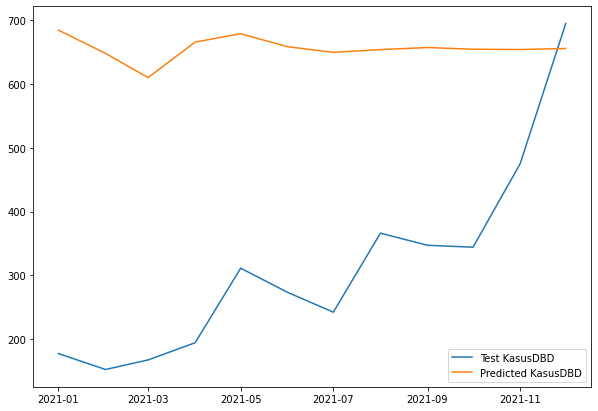

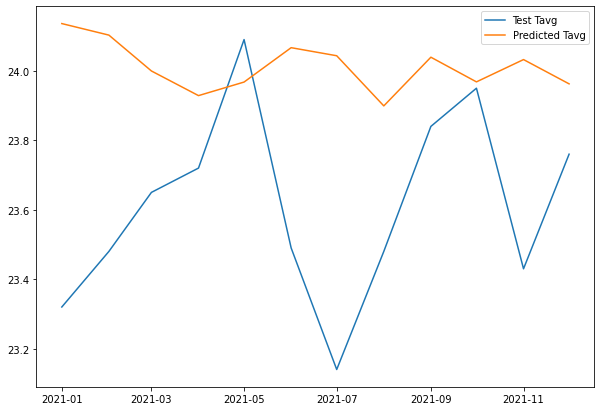

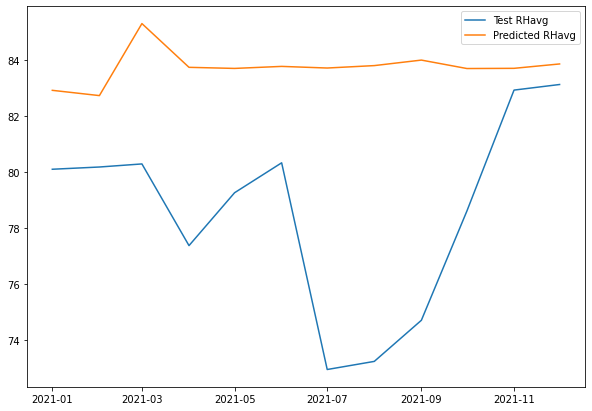

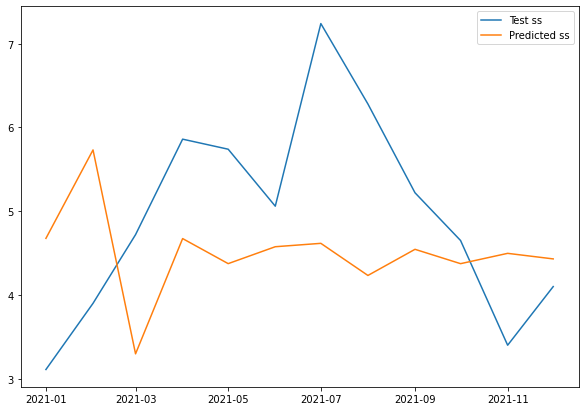

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['KasusDBD','Tavg','RHavg','ss' ]:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(inv_res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()